In [10]:
from backtesting import backtesting, Strategy, Backtest
from backtesting.lib import crossover, resample_apply, barssince
import talib
import pandas as pd
from talib import BBANDS
from backtesting.test import SMA
import yfinance as yf

### 股票資料

In [2]:
df = yf.download("1785.two", start="2019-06-27", end="2024-08-06", interval="1d")
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-27,20.765272,21.057741,20.716528,20.765272,17.951832,1798549
2019-06-28,20.765272,20.960253,20.521549,20.521549,17.741131,1666001
2019-07-01,20.667784,20.716528,19.936611,20.472803,17.698988,3546372


### 股票指標

sma: 簡單移動平均線

ema: 指數移動平均線

wma: 加權移動平均線

trima: 三角移動平均線


In [3]:
# 5-60日平均價格線
# c = df2["Close"]
c = df["Adj Close"]
c5 = c.rolling(5, min_periods=1).mean()
c10 = c.rolling(10, min_periods=1).mean()
c20 = c.rolling(20, min_periods=1).mean()
c60 = c.rolling(60, min_periods=1).mean()

# MA
ma5 = talib.SMA(df["Adj Close"], timeperiod=5)
ma10 = talib.SMA(df["Adj Close"], timeperiod=10)
ma20 = talib.SMA(df["Adj Close"], timeperiod=20)
ma60 = talib.SMA(df["Adj Close"], timeperiod=60)

# BBANDS
upperband, middleband, lowerband = BBANDS(df["Adj Close"], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

# kd值
kd = talib.STOCH(high=df["High"], low=df["Low"], close=c,fastk_period=9, slowk_period=3, slowd_period=3)
slowk = kd[0]
slowd = kd[1]

# MACD
normal_macd = talib.MACD(real=c, fastperiod=12, slowperiod=26, signalperiod=9)
macd_N, signal_N, hist_N = normal_macd
shorter_macd = talib.MACD(real=c, fastperiod=6, slowperiod=13, signalperiod=9)
macd_S, signal_S, hist_S = shorter_macd

# RSI
rsi5 = talib.RSI(real=c, timeperiod=5)
rsi10 = talib.RSI(real=c, timeperiod=10)
rsi20 = talib.RSI(real=c, timeperiod=20)
rsi60 = talib.RSI(real=c, timeperiod=60)

# MOM
mom5 = talib.MOM(df["Adj Close"], timeperiod=5)
mom10 = talib.MOM(df["Adj Close"], timeperiod=10)
mom20 = talib.MOM(df["Adj Close"], timeperiod=20)
mom60 = talib.MOM(df["Adj Close"], timeperiod=60)

# atr
atr5 = talib.ATR(df.High, df.Low, df.Close, timeperiod=5)

# obv
obv = talib.OBV(df.Close, df.Volume)

# roc
roc5 = talib.ROC(c, timeperiod=5)
roc10 = talib.ROC(c, timeperiod=10)
roc20 = talib.ROC(c, timeperiod=20)
roc60 = talib.ROC(c, timeperiod=60)

# Beta
beta5 = talib.BETA(df.High, df.Low, timeperiod=5)
beta10 = talib.BETA(df.High, df.Low, timeperiod=10)
beta20 = talib.BETA(df.High, df.Low, timeperiod=20)
beta60 = talib.BETA(df.High, df.Low, timeperiod=60)

# bias
bias = (c-c5)/c5

# volume rate
vol_rate = df.Volume.shift(-1)/df.Volume

In [6]:
# 指標df
df_indicator = pd.DataFrame({"price": c, "bias":bias, "ma5": ma5, "ma10": ma10, "ma20": ma20, "ma60": ma60, "rsi5": rsi5, "rsi10": rsi10, "slowk": slowk, "slowd": slowd, "obv": obv, "mom5": mom5, "roc5": roc5, "roc10": roc10, "roc20": roc20, "roc60": roc60, "beta5": beta5, "beta10": beta10, "beta20": beta20, "beta60": beta60}).fillna(0)
df_indicator.head(3)

,price,bias,ma5,ma10,ma20,ma60,rsi5,rsi10,slowk,slowd,obv,mom5,roc5,roc10,roc20,roc60,beta5,beta10,beta20,beta60
Date,,,,,,,,,,,,,,,,,,,,
2019-06-27,17.951832,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1798549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-28,17.741131,-0.005903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,17.698988,-0.005525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3413824.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 指標df correlation
df_corr = df_indicator.corr()
df_corr.head(5)

,price,bias,ma5,ma10,ma20,ma60,rsi5,rsi10,slowk,slowd,obv,mom5,roc5,roc10,roc20,roc60,beta5,beta10,beta20,beta60
price,1.000000,0.073537,0.990209,0.978060,0.953473,0.880844,0.085631,0.201261,0.490228,0.497272,0.781201,0.132633,0.090312,0.122802,0.199271,0.231970,-0.015724,-0.027907,0.024619,0.092548
bias,0.073537,1.000000,-0.024272,-0.055648,-0.079488,-0.066306,0.769039,0.663292,0.160121,0.093844,0.015964,0.781462,0.836667,0.585881,0.412459,0.187918,0.044842,0.004499,0.017727,0.003918
ma5,0.990209,-0.024272,1.000000,0.991084,0.968664,0.893318,0.022690,0.154476,0.465839,0.479374,0.778698,0.045513,0.009592,0.066864,0.158012,0.213788,-0.009318,-0.017599,0.037009,0.105999
ma10,0.978060,-0.055648,0.991084,1.000000,0.982875,0.907363,-0.019468,0.123243,0.435436,0.448546,0.774445,-0.015754,-0.047714,0.000171,0.109416,0.192211,-0.004353,-0.000688,0.052552,0.121747
ma20,0.953473,-0.079488,0.968664,0.982875,1.000000,0.933312,-0.072311,0.052643,0.410923,0.423435,0.765158,-0.050764,-0.082599,-0.076725,0.016764,0.143394,-0.003651,0.018049,0.090639,0.153802


<Axes: >

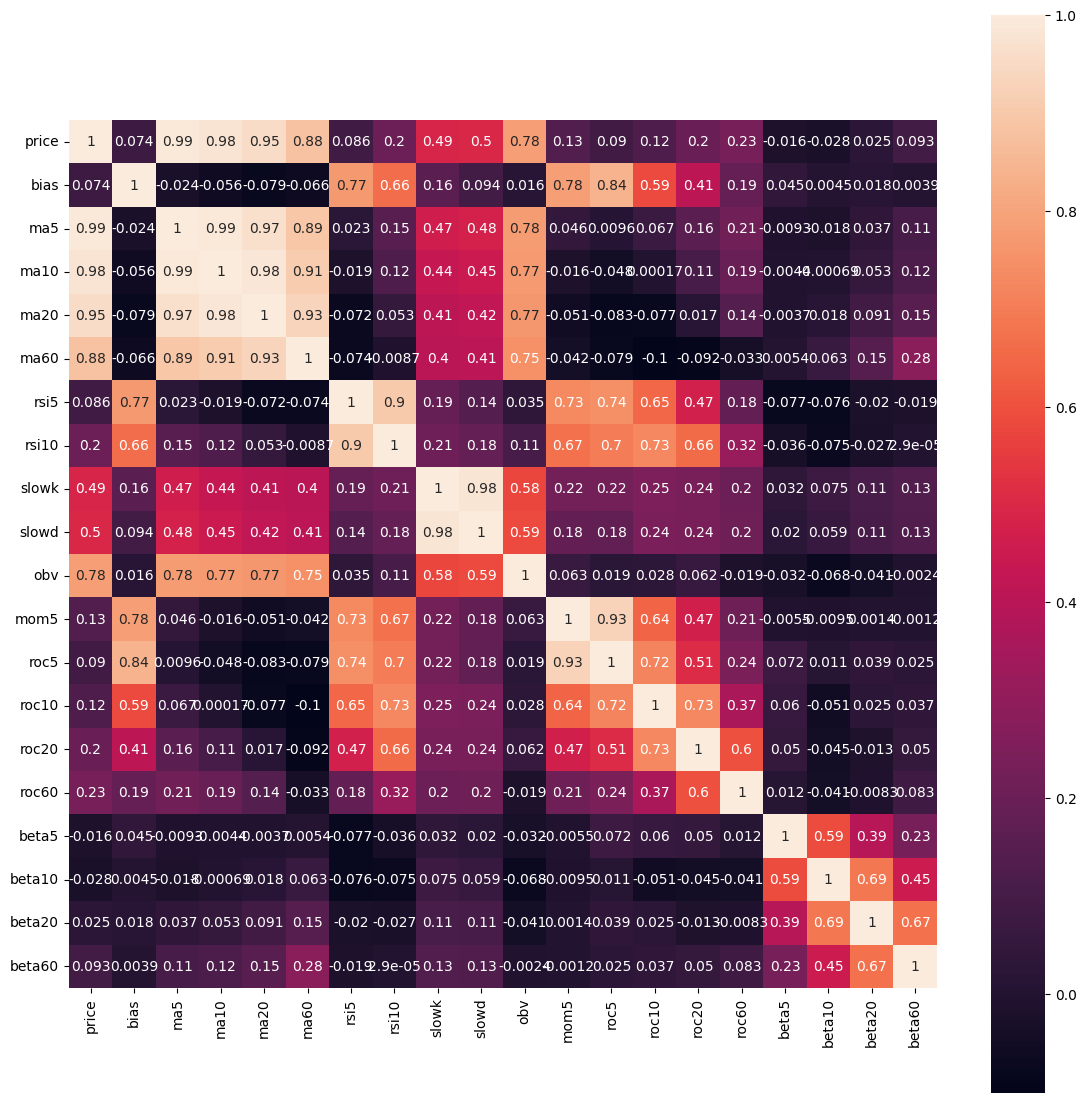

In [8]:
"""繪出熱像圖"""
# set figure size
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 14)

# original code
import seaborn as sns
sns.heatmap(df_corr, square=True ,vmax=1.0, linecolor='white', annot=True)

### backtesting 回測版本


- self.sell() 做空
- self.buy() 做多
- self.position.close() 平倉 sell everything we've got.

- 如果先做空，在下次做self.buy()之前，可以先執行self.position.close()把空單買回。
- 如果先做多，在下次做self.sell()之前，可以先執行self.position.close()把多單賣出。
- 所以self.position.close()都可以同時用。

- tp = take profit = 1.1 * price
- sl = stop loss = 0.95*price
- size = how much stock you want to buy according to your capital (percentage)

- _trades = 可以了解買賣狀況


In [11]:
# 基礎版本
"""SMA回測版本"""
class SmaCross(Strategy): #交易策略命名為SmaClass，使用backtesting.py的Strategy功能
    n1 = 5 #設定第一條均線日數為5日(周線)
    n2 = 20 #設定第二條均線日數為20日(月線)，這邊的日數可自由調整

    def init(self):
        super().init()
        self.sma1 = self.I(SMA, self.data.Close, self.n1) #定義第一條均線為sma1，使用backtesting.py的SMA功能算繪
        self.sma2 = self.I(SMA, self.data.Close, self.n2) #定義第二條均線為sma2，使用backtesting.py的SMA功能算繪

    def next(self):
        if crossover(self.sma1, self.sma2): #如果周線衝上月線，表示近期是上漲的，則買入
            self.buy()
        elif crossover(self.sma2, self.sma1): #如果周線再與月線交叉，表示開始下跌了，則賣出
            self.position.close()
            # self.sell()
            # print(self.trades)
            # if len(self.trades) > 0:
            #     self.trades[0].close()


bt = Backtest(df, SmaCross,
              cash=10000, commission=.004,
              exclusive_orders=True)

result = bt.run()
result

Start                     2019-06-27 00:00:00
End                       2024-08-05 00:00:00
Duration                   1866 days 00:00:00
Exposure Time [%]                   55.152979
Equity Final [$]                 22575.508526
Equity Peak [$]                  28241.827828
Return [%]                         125.755085
Buy & Hold Return [%]              167.754731
Return (Ann.) [%]                    17.96483
Volatility (Ann.) [%]               38.008403
Sharpe Ratio                         0.472654
Sortino Ratio                        0.971685
Calmar Ratio                          0.31312
Max. Drawdown [%]                  -57.373545
Avg. Drawdown [%]                   -9.844085
Max. Drawdown Duration     1484 days 00:00:00
Avg. Drawdown Duration      150 days 00:00:00
# Trades                                   38
Win Rate [%]                        36.842105
Best Trade [%]                     136.622586
Worst Trade [%]                    -10.919702
Avg. Trade [%]                    

In [ ]:
# 畫圖
bt.plot(filename="only_buy_sl_pt_islong_plpct", superimpose = False)

In [14]:
# 基礎版本- 修改測試版
"""SMA回測版本"""
class SmaCross(Strategy): #交易策略命名為SmaClass，使用backtesting.py的Strategy功能
    n1 = 5 #設定第一條均線日數為5日(周線)
    n2 = 20 #設定第二條均線日數為20日(月線)，這邊的日數可自由調整

    def init(self):
        super().init()
        self.sma1 = self.I(SMA, self.data.Close, self.n1) #定義第一條均線為sma1，使用backtesting.py的SMA功能算繪
        self.sma2 = self.I(SMA, self.data.Close, self.n2) #定義第二條均線為sma2，使用backtesting.py的SMA功能算繪

    def next(self):
        price = self.data.Close[-1]

        if crossover(self.sma1, self.sma2): #如果周線衝上月線，表示近期是上漲的，則買入
            # print(self.position.is_long)
            self.buy(sl = 0.95*price, tp=1.2*price)
        elif crossover(self.sma2, self.sma1): #如果周線再與月線交叉，表示開始下跌了，則賣出
            # print(self.position.is_long)
            if self.position.is_long:
                # print(str(self.position.pl_pct * 100) + " %")
                # self.position.close()
                self.trades[0].close()
        elif self.position.pl_pct < -.05:
            self.position.close()
            # self.sell()
            # print(self.trades)
            # if len(self.trades) > 0:
            #     self.trades[0].close()

        if self.trades:
            print(self.position.is_short)
            # print(self.trades[0].entry_price)
            # print(self.trades[0].pl)
            # print(self.trades[0].tp)
        # print(self.position.pl)
        if self.orders:
            print(self.orders)


bt = Backtest(df, SmaCross,
              cash=10000, commission=.004,
              exclusive_orders=True)

stats = bt.run()
stats

(<Order size=1.0, sl=20.931, tp=26.43916, contingent=0>,)
False
(<Order size=-450.0, stop=20.931, contingent=1>, <Order size=-450.0, limit=26.43916, contingent=1>)
False
(<Order size=-450.0, contingent=1>, <Order size=-450.0, stop=20.931, contingent=1>, <Order size=-450.0, limit=26.43916, contingent=1>)
(<Order size=1.0, sl=20.60685, tp=26.02971, contingent=0>,)
False
(<Order size=-440.0, stop=20.60685, contingent=1>, <Order size=-440.0, limit=26.02971, contingent=1>)
False
(<Order size=-440.0, stop=20.60685, contingent=1>, <Order size=-440.0, limit=26.02971, contingent=1>)
False
(<Order size=-440.0, stop=20.60685, contingent=1>, <Order size=-440.0, limit=26.02971, contingent=1>)
False
(<Order size=-440.0, stop=20.60685, contingent=1>, <Order size=-440.0, limit=26.02971, contingent=1>)
False
(<Order size=-440.0, stop=20.60685, contingent=1>, <Order size=-440.0, limit=26.02971, contingent=1>)
False
(<Order size=-440.0, stop=20.60685, contingent=1>, <Order size=-440.0, limit=26.02971, co

Start                     2019-06-27 00:00:00
End                       2024-08-05 00:00:00
Duration                   1866 days 00:00:00
Exposure Time [%]                   42.028986
Equity Final [$]                 12584.701453
Equity Peak [$]                  12700.763133
Return [%]                          25.847015
Buy & Hold Return [%]              167.754731
Return (Ann.) [%]                    4.775076
Volatility (Ann.) [%]               23.700384
Sharpe Ratio                         0.201477
Sortino Ratio                        0.353875
Calmar Ratio                         0.110625
Max. Drawdown [%]                  -43.164565
Avg. Drawdown [%]                   -8.050952
Max. Drawdown Duration     1382 days 00:00:00
Avg. Drawdown Duration      154 days 00:00:00
# Trades                                   38
Win Rate [%]                        36.842105
Best Trade [%]                      20.237279
Worst Trade [%]                     -8.480643
Avg. Trade [%]                    

In [15]:
# 查看交易紀錄
trades = result["_trades"]
trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,450,35,37,22.218647,21.301464,-412.732521,-0.041280,2019-08-16,2019-08-20,4 days
1,440,50,73,21.778189,22.325106,240.643285,0.025113,2019-09-06,2019-10-16,40 days
2,462,108,138,21.239852,21.788914,253.666332,0.025851,2019-12-04,2020-01-16,43 days
3,462,154,166,21.778189,21.350210,-197.726261,-0.019652,2020-02-18,2020-03-06,17 days
4,478,168,169,20.652575,20.765272,53.869424,0.005457,2020-03-10,2020-03-11,1 days
5,560,190,263,17.716189,41.920506,13554.417017,1.366226,2020-04-13,2020-07-28,106 days
6,572,289,292,41.011514,40.263184,-428.045067,-0.018247,2020-09-02,2020-09-07,5 days
7,553,293,308,41.696666,41.481804,-118.818998,-0.005153,2020-09-08,2020-09-29,21 days
8,525,316,329,43.703200,41.969250,-910.323676,-0.039676,2020-10-14,2020-11-02,19 days
9,485,337,360,45.367151,43.870296,-725.974347,-0.032994,2020-11-12,2020-12-15,33 days


In [17]:
"""KD回測版本"""
# kd = talib.STOCH(high=df2["High"], low=df2["Low"], close=c,fastk_period=9, slowk_period=3, slowd_period=3)
# https://quantpass.org/masterlink-6/
# https://hackmd.io/@s02260441/SkA7IWVJv

class KDtest(Strategy):
    top = 80
    bottom = 20
    
    def init(self):
        super().init()
        self.kd = self.I(talib.STOCH, self.data.High, self.data.Low, self.data.Close, fastk_period=9, slowk_period=3, slowd_period=3)
        # print(self.kd)
        self.slowk = self.kd[0]
        self.slowd = self.kd[1]
    
    def next(self):
        super().next()
        price = self.data.Close[-1]
        
        if not self.position:
            # print(self.position)
            if crossover(self.slowk, self.slowd):
                if self.position.is_short:
                    self.position.close()
                    self.buy()
                    
            elif crossover(self.slowd, self.slowk):
                if self.position.is_long:
                    self.position.close()
                    self.sell()
            else:
                pass

bt = Backtest(df, KDtest,
              cash=10000, commission=.004,
              exclusive_orders=True)

stats = bt.run()
stats

Start                     2019-06-27 00:00:00
End                       2024-08-05 00:00:00
Duration                   1866 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]              167.754731
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [18]:
"""RSI回測版本"""
class RSICross(Strategy):
    ceiling = 70
    bottom = 30
    n1 = 5
    n2 = 10
    n3 = 20
    def init(self):
        super().init()
        self.rsi5 = self.I(talib.RSI, self.data.Close, self.n1)
        self.rsi10 = self.I(talib.RSI, self.data.Close, self.n2)
        self.rsi20 = self.I(talib.RSI, self.data.Close, self.n3)

    def next(self):
        price = self.data.Close[-1]
        super().next()
        if crossover(self.bottom, self.rsi5):
            if self.position.is_short or not self.position: # 如果是多空，先平倉，然後再做多 (如果結果出現Nan，是因為沒有先去做單，才會無法判斷目前多單與空單狀態)
                self.position.close() 
                self.buy()
        
        # elif crossover(self.rsi5, self.rsi20):
        #     self.position.close()
        #     self.sell()
        
        # elif crossover(self.rsi20, self.rsi10):
        #     self.position.close()
        #     self.sell()
        
        # elif crossover(self.rsi20, self.rsi10):
        #     self.position.close()
        #     self.sell()
        # else:
        #     self.position.close()
        #     self.sell()
        elif crossover(self.rsi5, self.ceiling):
            if self.position.is_long or not self.position: # 如果是多單，先平倉，然後再做空
                self.position.close()
                self.sell()


bt = Backtest(df, RSICross,
              cash=10000, commission=.004,
              exclusive_orders=True) # exclusive_orders = True 代表一次只有一個交易
stats = bt.run()
stats

Start                     2019-06-27 00:00:00
End                       2024-08-05 00:00:00
Duration                   1866 days 00:00:00
Exposure Time [%]                   16.586151
Equity Final [$]                          0.0
Equity Peak [$]                  11902.977436
Return [%]                             -100.0
Buy & Hold Return [%]              167.754731
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              304.360867
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -20.622929
Max. Drawdown Duration     1609 days 00:00:00
Avg. Drawdown Duration      303 days 00:00:00
# Trades                                   11
Win Rate [%]                        63.636364
Best Trade [%]                       6.087275
Worst Trade [%]                   -116.609877
Avg. Trade [%]                    

In [19]:
"""bias回測版本"""
def bias(c: pd.Series, c5: pd.Series) -> pd.Series:
    bias = (c-c5)/c5
    return bias

class biastest(Strategy):
    def init(self):
        c = self.data.Close
        c5 = talib.SMA(c, timeperiod=5)
        self.bias = self.I(bias, c, c5)
    def next(self):
        if crossover(self.bias, 0):
            if not self.position:
                self.position.close()
                self.buy()
        elif crossover(0, self.bias):
            if self.position.is_long:
                self.position.close()

bt = Backtest(df, biastest, commission=.004, cash=10000, exclusive_orders=True)
stats = bt.run()
stats
# print(stats["_trades"].to_string())

Start                     2019-06-27 00:00:00
End                       2024-08-05 00:00:00
Duration                   1866 days 00:00:00
Exposure Time [%]                   63.043478
Equity Final [$]                  8114.444951
Equity Peak [$]                  24762.885727
Return [%]                          -18.85555
Buy & Hold Return [%]              167.754731
Return (Ann.) [%]                   -4.150744
Volatility (Ann.) [%]               30.485903
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -73.867347
Avg. Drawdown [%]                  -15.271619
Max. Drawdown Duration     1491 days 00:00:00
Avg. Drawdown Duration      229 days 00:00:00
# Trades                                  157
Win Rate [%]                        33.121019
Best Trade [%]                      58.457078
Worst Trade [%]                    -10.511797
Avg. Trade [%]                    